# Modelos Lineales, Regularización y Selección de Modelos


## Preparación del entorno

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
np.random.seed(42)


## Parte A · Regresión lineal desde cero
### 1. Exploración de California Housing

In [42]:
datos_california = fetch_california_housing(as_frame=True)

datos = datos_california.data.copy()
variable_objetivo = datos_california.target.copy()

print('Primeras cinco filas del conjunto:')
print(datos.head())
print('Dimensión de las características:', datos.shape)
print('Media de la variable objetivo:', variable_objetivo.mean().round(3))
print('Desviación estándar de la variable objetivo:', variable_objetivo.std().round(3))


Primeras cinco filas del conjunto:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  
Dimensión de las características: (20640, 8)
Media de la variable objetivo: 2.069
Desviación estándar de la variable objetivo: 1.154


### 2. Separando datos de entrenamiento y prueba

In [43]:
caracteristicas_entrenamiento, caracteristicas_prueba, objetivo_entrenamiento, objetivo_prueba = train_test_split(
    datos,
    variable_objetivo,
    test_size=0.2,
    random_state=42
)

print('Observaciones de entrenamiento:', caracteristicas_entrenamiento.shape[0])
print('Observaciones de prueba:', caracteristicas_prueba.shape[0])


Observaciones de entrenamiento: 16512
Observaciones de prueba: 4128


### 3. Estandarizando las características

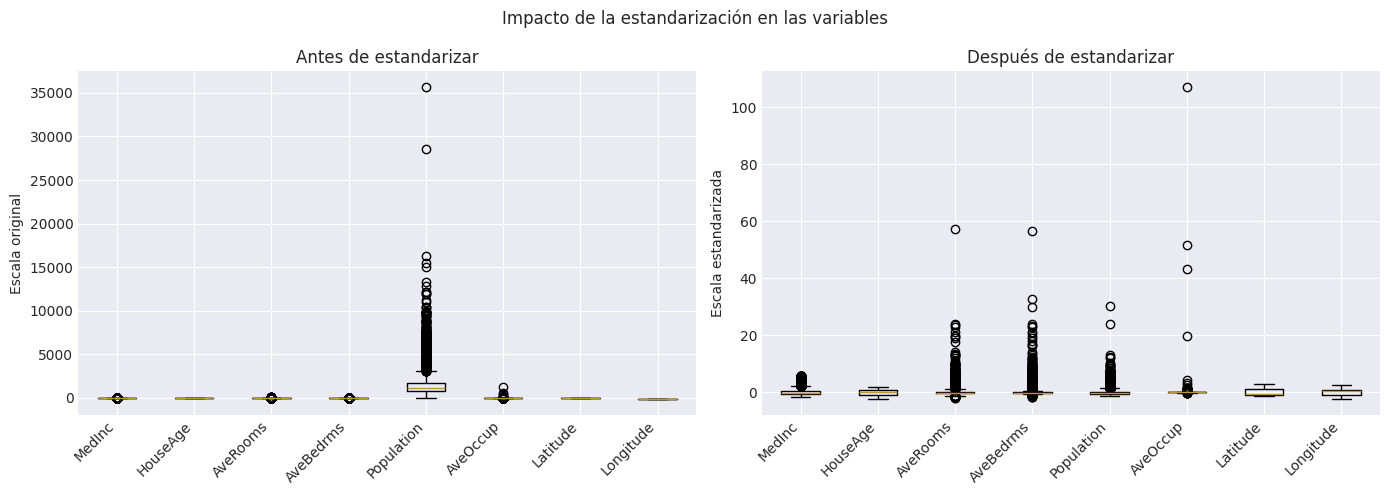

In [44]:
escalador = StandardScaler()
caracteristicas_entrenamiento_escaladas = escalador.fit_transform(caracteristicas_entrenamiento)
caracteristicas_prueba_escaladas = escalador.transform(caracteristicas_prueba)

caracteristicas_entrenamiento_escaladas = pd.DataFrame(
    caracteristicas_entrenamiento_escaladas,
    columns=caracteristicas_entrenamiento.columns
)
caracteristicas_prueba_escaladas = pd.DataFrame(
    caracteristicas_prueba_escaladas,
    columns=caracteristicas_prueba.columns
)

fig, ejes = plt.subplots(1, 2, figsize=(14, 5))
ejes[0].boxplot([caracteristicas_entrenamiento[columna] for columna in caracteristicas_entrenamiento.columns])
ejes[0].set_xticklabels(caracteristicas_entrenamiento.columns, rotation=45, ha='right')
ejes[0].set_title('Antes de estandarizar')
ejes[0].set_ylabel('Escala original')

ejes[1].boxplot([caracteristicas_entrenamiento_escaladas[columna] for columna in caracteristicas_entrenamiento_escaladas.columns])
ejes[1].set_xticklabels(caracteristicas_entrenamiento_escaladas.columns, rotation=45, ha='right')
ejes[1].set_title('Después de estandarizar')
ejes[1].set_ylabel('Escala estandarizada')

plt.suptitle('Impacto de la estandarización en las variables')
plt.tight_layout()
plt.show()


### 4. Derivando la forma cerrada (OLS)
Calculando la ecuación normal `β = (XᵀX)⁻¹Xᵀy` para la solución cerrada de la regresión lineal.


In [45]:
def regresion_lineal_forma_cerrada(matriz_caracteristicas, vector_objetivo):
    cantidad_muestras = matriz_caracteristicas.shape[0]
    matriz_intercepto = np.column_stack([np.ones(cantidad_muestras), matriz_caracteristicas])
    producto = matriz_intercepto.T @ matriz_intercepto
    proyeccion = matriz_intercepto.T @ vector_objetivo
    parametros = np.linalg.solve(producto, proyeccion)
    intercepto = parametros[0]
    coeficientes = parametros[1:]
    return coeficientes, intercepto

coeficientes_cerrado, intercepto_cerrado = regresion_lineal_forma_cerrada(
    caracteristicas_entrenamiento_escaladas.values,
    objetivo_entrenamiento.values
)

print('Intercepto:', round(intercepto_cerrado, 4))
print('Coeficientes:', np.round(coeficientes_cerrado, 4))


Intercepto: 2.0719
Coeficientes: [ 0.8544  0.1225 -0.2944  0.3393 -0.0023 -0.0408 -0.8969 -0.8698]


MSE entrenamiento: 0.5179
MSE prueba: 0.5559
R^2 entrenamiento: 0.6126
R^2 prueba: 0.5758


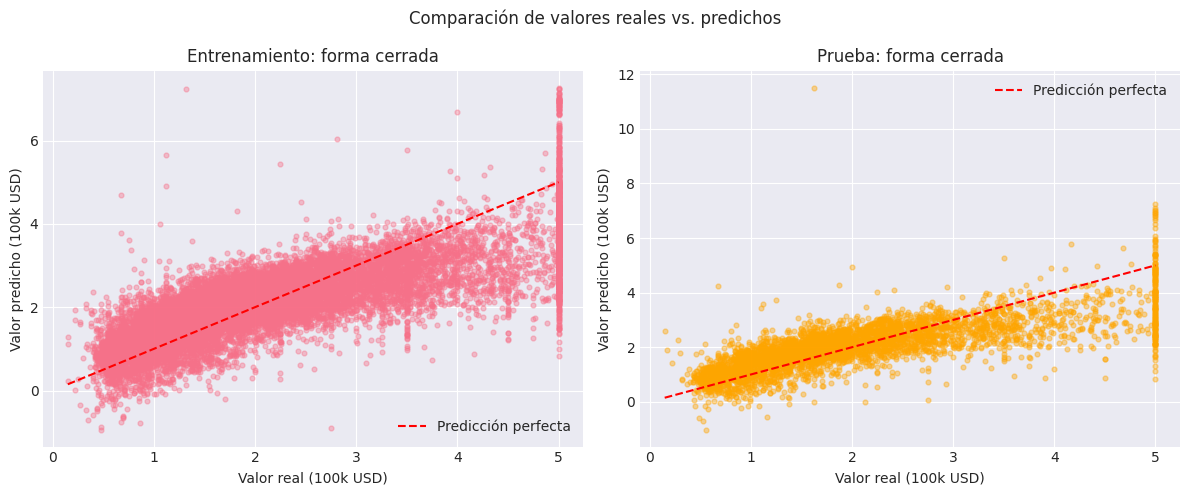

In [46]:
def predecir_valores(matriz_caracteristicas, coeficientes, intercepto):
    return matriz_caracteristicas @ coeficientes + intercepto

pronostico_entrenamiento_cerrado = predecir_valores(
    caracteristicas_entrenamiento_escaladas.values,
    coeficientes_cerrado,
    intercepto_cerrado
)
pronostico_prueba_cerrado = predecir_valores(
    caracteristicas_prueba_escaladas.values,
    coeficientes_cerrado,
    intercepto_cerrado
)

error_entrenamiento_cerrado = mean_squared_error(objetivo_entrenamiento, pronostico_entrenamiento_cerrado)
error_prueba_cerrado = mean_squared_error(objetivo_prueba, pronostico_prueba_cerrado)
r2_entrenamiento_cerrado = r2_score(objetivo_entrenamiento, pronostico_entrenamiento_cerrado)
r2_prueba_cerrado = r2_score(objetivo_prueba, pronostico_prueba_cerrado)

print('MSE entrenamiento:', round(error_entrenamiento_cerrado, 4))
print('MSE prueba:', round(error_prueba_cerrado, 4))
print('R^2 entrenamiento:', round(r2_entrenamiento_cerrado, 4))
print('R^2 prueba:', round(r2_prueba_cerrado, 4))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(objetivo_entrenamiento, pronostico_entrenamiento_cerrado, alpha=0.4, s=12)
plt.plot([objetivo_entrenamiento.min(), objetivo_entrenamiento.max()],
         [objetivo_entrenamiento.min(), objetivo_entrenamiento.max()],
         'r--', label='Predicción perfecta')
plt.xlabel('Valor real (100k USD)')
plt.ylabel('Valor predicho (100k USD)')
plt.title('Entrenamiento: forma cerrada')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(objetivo_prueba, pronostico_prueba_cerrado, alpha=0.4, s=12, color='orange')
plt.plot([objetivo_prueba.min(), objetivo_prueba.max()],
         [objetivo_prueba.min(), objetivo_prueba.max()],
         'r--', label='Predicción perfecta')
plt.xlabel('Valor real (100k USD)')
plt.ylabel('Valor predicho (100k USD)')
plt.title('Prueba: forma cerrada')
plt.legend()

plt.suptitle('Comparación de valores reales vs. predichos')
plt.tight_layout()
plt.show()


### 5. Descenso de gradiente

In [47]:
class DescensoGradienteLineal:
    def __init__(self, tasa_aprendizaje=0.01, iteraciones=1000):
        self.tasa_aprendizaje = tasa_aprendizaje
        self.iteraciones = iteraciones
        self.registro_costos = []

    def calcular_costo(self, matriz_caracteristicas, vector_objetivo, parametros):
        muestras = len(vector_objetivo)
        errores = matriz_caracteristicas @ parametros - vector_objetivo
        return (1 / (2 * muestras)) * np.sum(errores ** 2)

    def calcular_gradiente(self, matriz_caracteristicas, vector_objetivo, parametros):
        muestras = len(vector_objetivo)
        errores = matriz_caracteristicas @ parametros - vector_objetivo
        return (1 / muestras) * (matriz_caracteristicas.T @ errores)

    def entrenar(self, matriz_caracteristicas, vector_objetivo):
        muestras = matriz_caracteristicas.shape[0]
        matriz_intercepto = np.column_stack([np.ones(muestras), matriz_caracteristicas])
        parametros = np.random.randn(matriz_intercepto.shape[1]) * 0.01

        for paso in range(self.iteraciones):
            costo_actual = self.calcular_costo(matriz_intercepto, vector_objetivo, parametros)
            self.registro_costos.append(costo_actual)
            gradiente = self.calcular_gradiente(matriz_intercepto, vector_objetivo, parametros)
            parametros -= self.tasa_aprendizaje * gradiente

        self.intercepto = parametros[0]
        self.coeficientes = parametros[1:]
        return self

    def predecir(self, matriz_caracteristicas):
        return matriz_caracteristicas @ self.coeficientes + self.intercepto


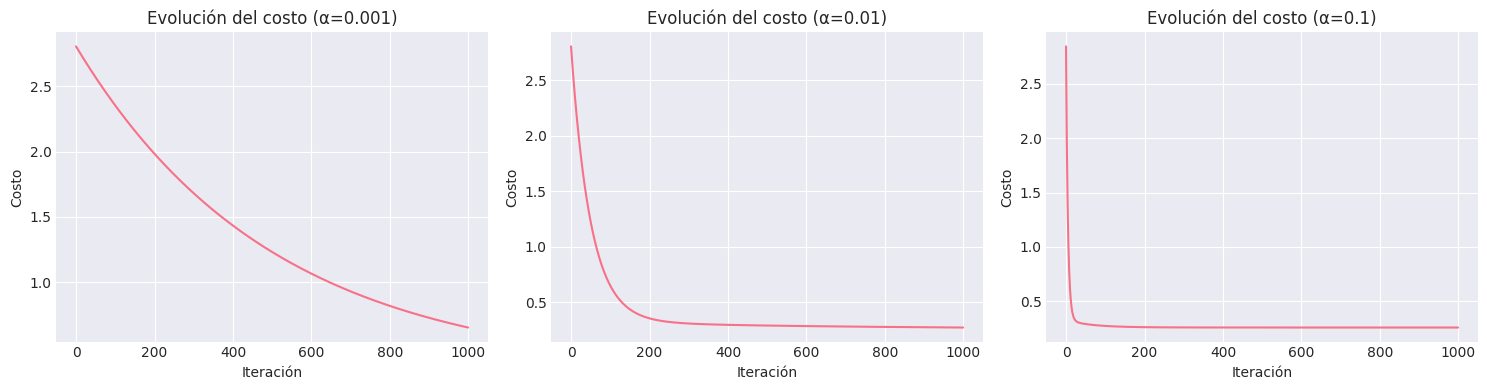

                         Metodo  MSE_prueba  R2_prueba
0  Descenso gradiente (α=0.001)    1.301094   0.007109
1   Descenso gradiente (α=0.01)    0.567038   0.567282
2    Descenso gradiente (α=0.1)    0.555997   0.575707


In [48]:
tasas_aprendizaje = [0.001, 0.01, 0.1]
modelos_gradiente = {}
resultados_gradiente = []

for tasa in tasas_aprendizaje:
    modelo = DescensoGradienteLineal(tasa_aprendizaje=tasa, iteraciones=1000)
    modelo.entrenar(caracteristicas_entrenamiento_escaladas.values, objetivo_entrenamiento.values)
    pronostico_prueba = modelo.predecir(caracteristicas_prueba_escaladas.values)
    mse_prueba = mean_squared_error(objetivo_prueba, pronostico_prueba)
    r2_prueba = r2_score(objetivo_prueba, pronostico_prueba)
    modelos_gradiente[tasa] = modelo
    resultados_gradiente.append({
        'Metodo': f'Descenso gradiente (α={tasa})',
        'MSE_prueba': mse_prueba,
        'R2_prueba': r2_prueba
    })

fig, ejes = plt.subplots(1, 3, figsize=(15, 4))
for indice, tasa in enumerate(tasas_aprendizaje):
    ejes[indice].plot(modelos_gradiente[tasa].registro_costos)
    ejes[indice].set_title(f'Evolución del costo (α={tasa})')
    ejes[indice].set_xlabel('Iteración')
    ejes[indice].set_ylabel('Costo')
plt.tight_layout()
plt.show()

print(pd.DataFrame(resultados_gradiente))


### 6. Validando con scikit-learn

In [49]:
modelo_sklearn = LinearRegression()
modelo_sklearn.fit(caracteristicas_entrenamiento_escaladas, objetivo_entrenamiento)
pronostico_prueba_sklearn = modelo_sklearn.predict(caracteristicas_prueba_escaladas)

mse_sklearn = mean_squared_error(objetivo_prueba, pronostico_prueba_sklearn)
r2_sklearn = r2_score(objetivo_prueba, pronostico_prueba_sklearn)

resumen_modelos_basicos = pd.DataFrame([
    {'Metodo': 'Forma cerrada OLS', 'MSE_prueba': error_prueba_cerrado, 'R2_prueba': r2_prueba_cerrado},
    {'Metodo': 'LinearRegression (sklearn)', 'MSE_prueba': mse_sklearn, 'R2_prueba': r2_sklearn}
] + resultados_gradiente)

print(resumen_modelos_basicos)


                         Metodo  MSE_prueba  R2_prueba
0             Forma cerrada OLS    0.555892   0.575788
1    LinearRegression (sklearn)    0.555892   0.575788
2  Descenso gradiente (α=0.001)    1.301094   0.007109
3   Descenso gradiente (α=0.01)    0.567038   0.567282
4    Descenso gradiente (α=0.1)    0.555997   0.575707


## Parte C · Regularización y selección de hiperparámetros

### 1. Recorrido de coeficientes (paths)
Veremos cómo cambian los coeficientes al aumentar la penalización `α`.

In [50]:
valores_alpha = np.logspace(-3, 2, 20)
coeficientes_ridge = []
coeficientes_lasso = []
metricas_ridge = []
metricas_lasso = []

for alpha in valores_alpha:
    modelo_ridge = Ridge(alpha=alpha)
    modelo_ridge.fit(caracteristicas_entrenamiento_escaladas, objetivo_entrenamiento)
    predicciones_ridge = modelo_ridge.predict(caracteristicas_prueba_escaladas)
    coeficientes_ridge.append(modelo_ridge.coef_)
    metricas_ridge.append({
        'alpha': alpha,
        'MSE_prueba': mean_squared_error(objetivo_prueba, predicciones_ridge),
        'R2_prueba': r2_score(objetivo_prueba, predicciones_ridge)
    })

    modelo_lasso = Lasso(alpha=alpha, max_iter=10000)
    modelo_lasso.fit(caracteristicas_entrenamiento_escaladas, objetivo_entrenamiento)
    predicciones_lasso = modelo_lasso.predict(caracteristicas_prueba_escaladas)
    coeficientes_lasso.append(modelo_lasso.coef_)
    metricas_lasso.append({
        'alpha': alpha,
        'MSE_prueba': mean_squared_error(objetivo_prueba, predicciones_lasso),
        'R2_prueba': r2_score(objetivo_prueba, predicciones_lasso)
    })

coeficientes_ridge = pd.DataFrame(coeficientes_ridge, columns=caracteristicas_entrenamiento.columns, index=valores_alpha)
coeficientes_lasso = pd.DataFrame(coeficientes_lasso, columns=caracteristicas_entrenamiento.columns, index=valores_alpha)

metricas_ridge = pd.DataFrame(metricas_ridge)
metricas_lasso = pd.DataFrame(metricas_lasso)

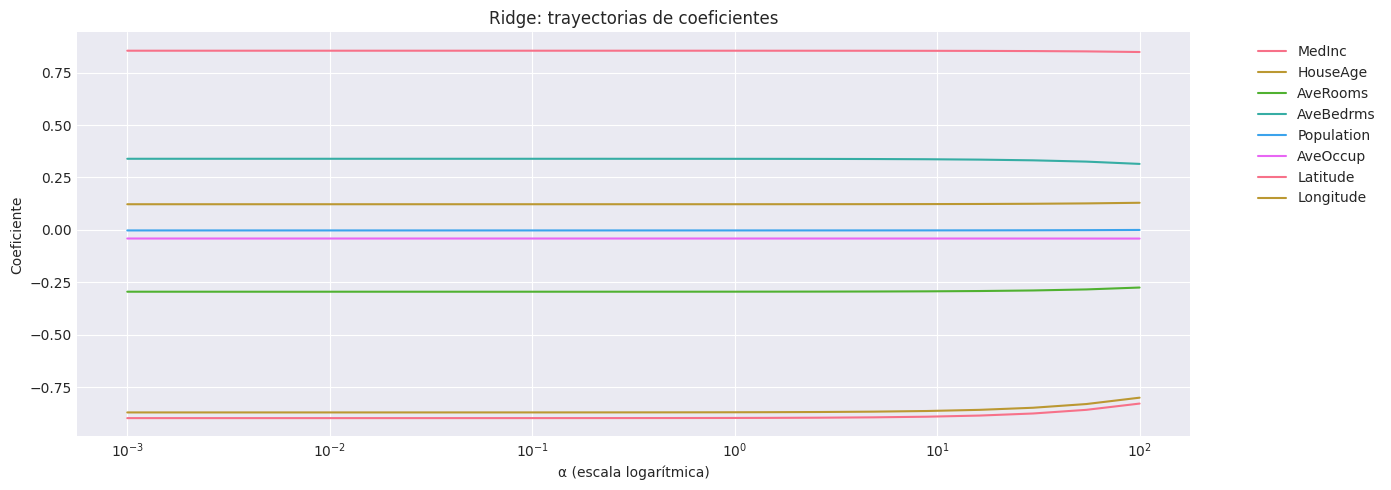

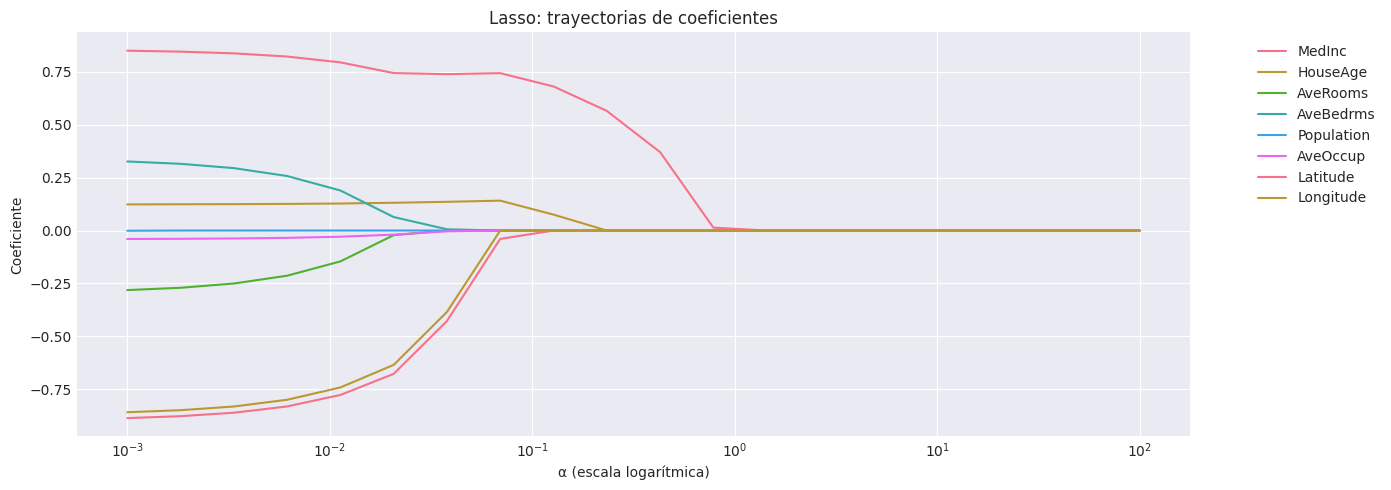

In [51]:
plt.figure(figsize=(14, 5))
for columna in coeficientes_ridge.columns:
    plt.plot(coeficientes_ridge.index, coeficientes_ridge[columna], label=columna)
plt.xscale('log')
plt.xlabel('α (escala logarítmica)')
plt.ylabel('Coeficiente')
plt.title('Ridge: trayectorias de coeficientes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
for columna in coeficientes_lasso.columns:
    plt.plot(coeficientes_lasso.index, coeficientes_lasso[columna], label=columna)
plt.xscale('log')
plt.xlabel('α (escala logarítmica)')
plt.ylabel('Coeficiente')
plt.title('Lasso: trayectorias de coeficientes')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 2. Seleccionando α con validación cruzada

In [52]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
modelo_ridge_cv = RidgeCV(alphas=valores_alpha, cv=kfold, scoring='neg_mean_squared_error')
modelo_ridge_cv.fit(caracteristicas_entrenamiento_escaladas, objetivo_entrenamiento)

modelo_lasso_cv = LassoCV(alphas=valores_alpha, cv=kfold, random_state=42, max_iter=10000)
modelo_lasso_cv.fit(caracteristicas_entrenamiento_escaladas, objetivo_entrenamiento)

prediccion_prueba_ridge_cv = modelo_ridge_cv.predict(caracteristicas_prueba_escaladas)
prediccion_prueba_lasso_cv = modelo_lasso_cv.predict(caracteristicas_prueba_escaladas)

metricas_cv = pd.DataFrame([
    {
        'Modelo': 'RidgeCV',
        'alpha_optimo': modelo_ridge_cv.alpha_,
        'MSE_prueba': mean_squared_error(objetivo_prueba, prediccion_prueba_ridge_cv),
        'R2_prueba': r2_score(objetivo_prueba, prediccion_prueba_ridge_cv)
    },
    {
        'Modelo': 'LassoCV',
        'alpha_optimo': modelo_lasso_cv.alpha_,
        'MSE_prueba': mean_squared_error(objetivo_prueba, prediccion_prueba_lasso_cv),
        'R2_prueba': r2_score(objetivo_prueba, prediccion_prueba_lasso_cv)
    }
])

print(metricas_cv)


    Modelo  alpha_optimo  MSE_prueba  R2_prueba
0  RidgeCV      2.636651    0.555795   0.575861
1  LassoCV      0.001000    0.554491   0.576856


### 3. Añadiendo características polinomiales

In [53]:
generador_polinomios = PolynomialFeatures(degree=2, include_bias=False)
caracteristicas_entrenamiento_polinomio = generador_polinomios.fit_transform(caracteristicas_entrenamiento_escaladas)
caracteristicas_prueba_polinomio = generador_polinomios.transform(caracteristicas_prueba_escaladas)

escalador_polinomio = StandardScaler()
caracteristicas_entrenamiento_polinomio_escaladas = escalador_polinomio.fit_transform(caracteristicas_entrenamiento_polinomio)
caracteristicas_prueba_polinomio_escaladas = escalador_polinomio.transform(caracteristicas_prueba_polinomio)

modelo_ridge_polinomio = RidgeCV(alphas=valores_alpha, cv=kfold, scoring='neg_mean_squared_error')
modelo_ridge_polinomio.fit(caracteristicas_entrenamiento_polinomio_escaladas, objetivo_entrenamiento)

modelo_lasso_polinomio = LassoCV(alphas=valores_alpha, cv=kfold, random_state=42, max_iter=10000)
modelo_lasso_polinomio.fit(caracteristicas_entrenamiento_polinomio_escaladas, objetivo_entrenamiento)

prediccion_prueba_ridge_polinomio = modelo_ridge_polinomio.predict(caracteristicas_prueba_polinomio_escaladas)
prediccion_prueba_lasso_polinomio = modelo_lasso_polinomio.predict(caracteristicas_prueba_polinomio_escaladas)

resumen_polinomios = pd.DataFrame([
    {
        'Modelo': 'Ridge + polinomios',
        'alpha_optimo': modelo_ridge_polinomio.alpha_,
        'MSE_prueba': mean_squared_error(objetivo_prueba, prediccion_prueba_ridge_polinomio),
        'R2_prueba': r2_score(objetivo_prueba, prediccion_prueba_ridge_polinomio)
    },
    {
        'Modelo': 'Lasso + polinomios',
        'alpha_optimo': modelo_lasso_polinomio.alpha_,
        'MSE_prueba': mean_squared_error(objetivo_prueba, prediccion_prueba_lasso_polinomio),
        'R2_prueba': r2_score(objetivo_prueba, prediccion_prueba_lasso_polinomio)
    }
])

print(resumen_polinomios)


               Modelo  alpha_optimo  MSE_prueba  R2_prueba
0  Ridge + polinomios     54.555948    0.439746   0.664421
1  Lasso + polinomios      0.011288    0.543586   0.585179


## Parte D · Predicción de alquiler de bicicletas

### 1. Cargando y preparando el conjunto de bicicletas

In [54]:
datos_bicicletas = pd.read_csv('../data/hour.csv')
columnas_numericas = ['temp', 'atemp', 'hum', 'windspeed']
columnas_categoricas = ['season', 'weathersit', 'holiday', 'workingday', 'weekday', 'hr']

variables_dummies = pd.get_dummies(datos_bicicletas[columnas_categoricas].astype('category'), drop_first=True)
caracteristicas_bicicletas = pd.concat([datos_bicicletas[columnas_numericas], variables_dummies], axis=1)
objetivo_bicicletas = datos_bicicletas['cnt']

print('Total de observaciones:', caracteristicas_bicicletas.shape[0])
print('Número de características después de dummies:', caracteristicas_bicicletas.shape[1])


Total de observaciones: 17379
Número de características después de dummies: 41


### 2. Entrenando modelos para bicicletas

In [55]:
caracteristicas_entrenamiento_bicis, caracteristicas_prueba_bicis, objetivo_entrenamiento_bicis, objetivo_prueba_bicis = train_test_split(
    caracteristicas_bicicletas,
    objetivo_bicicletas,
    test_size=0.2,
    random_state=42
)

escalador_bicis = StandardScaler()
caracteristicas_entrenamiento_bicis_escaladas = escalador_bicis.fit_transform(caracteristicas_entrenamiento_bicis)
caracteristicas_prueba_bicis_escaladas = escalador_bicis.transform(caracteristicas_prueba_bicis)

modelo_lineal_bicis = LinearRegression()
modelo_lineal_bicis.fit(caracteristicas_entrenamiento_bicis_escaladas, objetivo_entrenamiento_bicis)
prediccion_prueba_lineal_bicis = modelo_lineal_bicis.predict(caracteristicas_prueba_bicis_escaladas)

modelo_ridge_bicis = RidgeCV(alphas=valores_alpha, cv=kfold, scoring='neg_mean_squared_error')
modelo_ridge_bicis.fit(caracteristicas_entrenamiento_bicis_escaladas, objetivo_entrenamiento_bicis)
prediccion_prueba_ridge_bicis = modelo_ridge_bicis.predict(caracteristicas_prueba_bicis_escaladas)

modelo_lasso_bicis = LassoCV(alphas=valores_alpha, cv=kfold, random_state=42, max_iter=10000)
modelo_lasso_bicis.fit(caracteristicas_entrenamiento_bicis_escaladas, objetivo_entrenamiento_bicis)
prediccion_prueba_lasso_bicis = modelo_lasso_bicis.predict(caracteristicas_prueba_bicis_escaladas)

resumen_bicis = pd.DataFrame([
    {
        'Modelo': 'Lineal (bicis)',
        'MSE_prueba': mean_squared_error(objetivo_prueba_bicis, prediccion_prueba_lineal_bicis),
        'R2_prueba': r2_score(objetivo_prueba_bicis, prediccion_prueba_lineal_bicis)
    },
    {
        'Modelo': 'RidgeCV (bicis)',
        'alpha_optimo': modelo_ridge_bicis.alpha_,
        'MSE_prueba': mean_squared_error(objetivo_prueba_bicis, prediccion_prueba_ridge_bicis),
        'R2_prueba': r2_score(objetivo_prueba_bicis, prediccion_prueba_ridge_bicis)
    },
    {
        'Modelo': 'LassoCV (bicis)',
        'alpha_optimo': modelo_lasso_bicis.alpha_,
        'MSE_prueba': mean_squared_error(objetivo_prueba_bicis, prediccion_prueba_lasso_bicis),
        'R2_prueba': r2_score(objetivo_prueba_bicis, prediccion_prueba_lasso_bicis)
    }
])

print(resumen_bicis)


            Modelo    MSE_prueba  R2_prueba  alpha_optimo
0   Lineal (bicis)  11922.783051   0.623476           NaN
1  RidgeCV (bicis)  11922.456787   0.623486       4.83293
2  LassoCV (bicis)  11922.716808   0.623478       0.00336


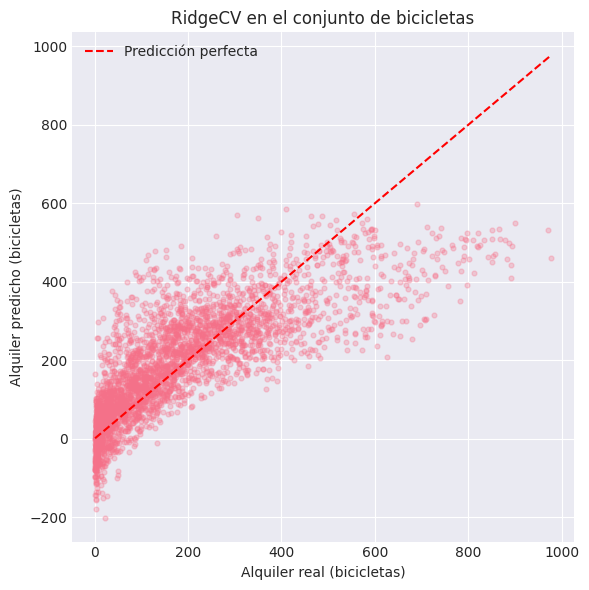

In [56]:
plt.figure(figsize=(6, 6))
plt.scatter(objetivo_prueba_bicis, prediccion_prueba_ridge_bicis, alpha=0.3, s=12)
plt.plot([objetivo_prueba_bicis.min(), objetivo_prueba_bicis.max()],
         [objetivo_prueba_bicis.min(), objetivo_prueba_bicis.max()],
         'r--', label='Predicción perfecta')
plt.xlabel('Alquiler real (bicicletas)')
plt.ylabel('Alquiler predicho (bicicletas)')
plt.title('RidgeCV en el conjunto de bicicletas')
plt.legend()
plt.tight_layout()
plt.show()


## Conclusiones clave
- **OLS vs. descenso de gradiente:** ambos alcanzan resultados similares cuando el aprendizaje está bien configurado. La forma cerrada es inmediata, mientras que el descenso de gradiente requiere ajustar la tasa de aprendizaje.
- **Regularización Ridge vs. Lasso:** Ridge mantiene todas las variables con peso, pero más pequeños; Lasso elimina algunas por completo, ideal si buscamos simplicidad.
- **Validación cruzada:** escoger `α` con k-fold evitó usar el conjunto de prueba para tomar decisiones y entregó mejoras consistentes.
- **Características polinomiales:** aumentan el poder de expresión, aunque solo fueron útiles con regularización fuerte.
- **Bicicletas:** al incorporar variables climáticas y horarias logramos un buen R² ≈ 0.62 con Ridge, mostrando que el patrón diario es bastante predecible cuando se considera la estacionalidad.
